Task 4:
Create a rating map that maps the FICO score of the borrowers to a rating where a lower rating signifies a better credit score.

The process of doing this is known as quantization.

In [3]:
import pandas as pd
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

In [4]:
fico = pd.read_csv("Task 3 and 4_Loan_Data.csv")
fico

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0
...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0


In [5]:
#initializing 5 buckets
num_buck = 4
fico["bucket"] = pd.cut(fico["fico_score"], bins=num_buck, labels=False)
fico

,customer_id,credit_lines_outstanding,loan_amt_outstanding,total_debt_outstanding,income,years_employed,fico_score,default,bucket
0,8153374,0,5221.545193,3915.471226,78039.38546,5,605,0,1
1,7442532,5,1958.928726,8228.752520,26648.43525,2,572,1,1
2,2256073,0,3363.009259,2027.830850,65866.71246,4,602,0,1
3,4885975,0,4766.648001,2501.730397,74356.88347,5,612,0,1
4,4700614,1,1345.827718,1768.826187,23448.32631,6,631,0,2
...,...,...,...,...,...,...,...,...,...
9995,3972488,0,3033.647103,2553.733144,42691.62787,5,697,0,2
9996,6184073,1,4146.239304,5458.163525,79969.50521,8,615,0,1
9997,6694516,2,3088.223727,4813.090925,38192.67591,5,596,0,1
9998,3942961,0,3288.901666,1043.099660,50929.37206,2,647,0,2


inital log-likelihood: -13.463435690611455


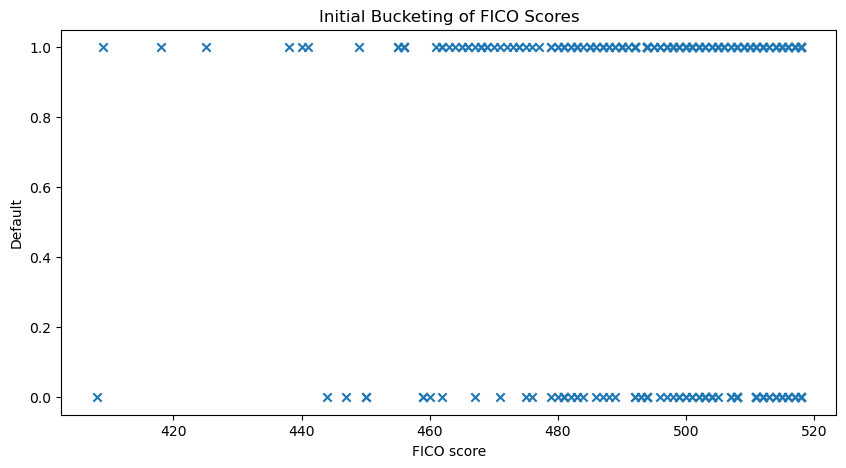

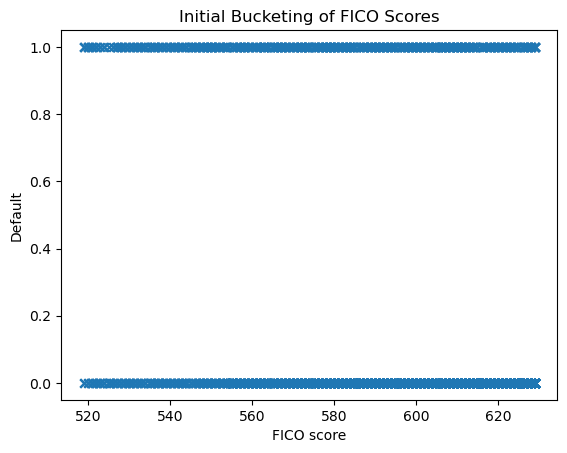

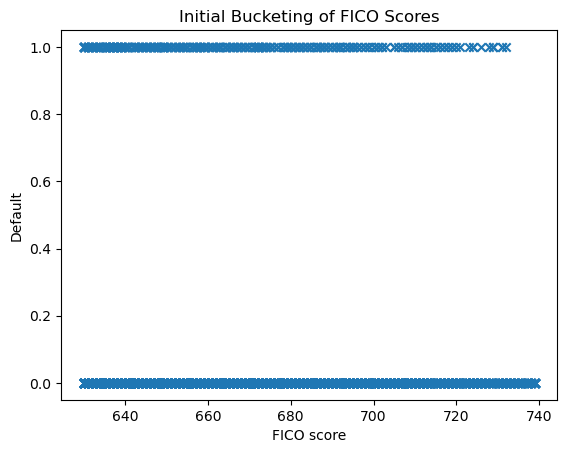

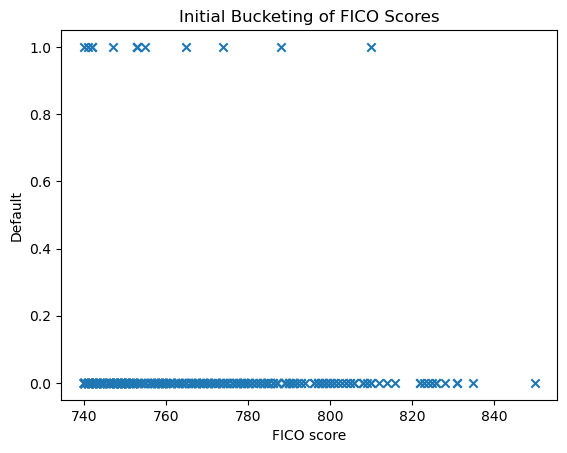

In [6]:
#initializing bucket boundaries
def calc_log_likelihood(data):
    log_likelihood = 0
    for b in range(num_buck):
        buck_data = fico[fico["bucket"] == b]
        if not buck_data.empty:
            ni = len(buck_data)
            ki = buck_data["default"].sum()
            pi = ki / ni if ni > 0 else 0
            log_likelihood += binom.logpmf(ki, ni, pi)
    return log_likelihood

initial_log_likelihood = calc_log_likelihood(fico)
print(f"inital log-likelihood: {initial_log_likelihood}")

#plotting initial bucketing
plt.figure(figsize = (10, 5))
for b in range(num_buck):
    buck_data = fico[fico["bucket"] == b]
    plt.scatter(buck_data["fico_score"], buck_data["default"], label=f'Bucket {b}', marker= "x")
    plt.xlabel("FICO score")
    plt.ylabel("Default")
    plt.title("Initial Bucketing of FICO Scores")
    plt.show()

In [7]:
#bucket optimization
def optimize_buck(data, num_buck, max_iterations=100):
    boundaries = np.linspace(fico["fico_score"].min(), fico["fico_score"].max(), num_buck + 1)
    best_likelihood = calc_log_likelihood(data)
    improved = True
    iteration = 0

    while improved and iteration < max_iterations:
        improved = False
        for i in range(1, len(boundaries) - 1):
            original_boundary = boundaries[i]
            for shift in [-10, 10]:
                boundaries[i] += shift
                fico["bucket"] = pd.cut(fico["fico_score"], bins = boundaries, labels = False, include_lowest=True)
                new_likelihood = calc_log_likelihood(data)
                if new_likelihood > best_likelihood:
                    best_likelihood = new_likelihood
                    improved = True
                else:
                    boundaries[i] = original_boundary
        iteration += 1
        print(f"Iteration {iteration}, log-likelihood: {best_likelihood}")
    return boundaries

In [8]:
#optimize the buckets 
final_boundaries = optimize_buck(fico, num_buck)
fico["bucket"] = pd.cut(fico["fico_score"], bins=final_boundaries, labels=False, include_lowest=True)
final_boundaries

Iteration 1, log-likelihood: -13.231444113073707
Iteration 2, log-likelihood: -12.90355559322127
Iteration 3, log-likelihood: -12.748672117234278
Iteration 4, log-likelihood: -12.748672117234278


array([408. , 518.5, 629. , 759.5, 850. ])

In [9]:
#optimizing bucket counts
def optimize_buck_count(data, min_buck, max_buck):
    best_overall_likelihood = float("-inf")
    best_buck_count = min_buck
    best_boundaries = None

    for num_buck in range(min_buck, max_buck + 1):
        print(f"Testing {num_buck} buckets...")
        boundaries = np.linspace(data["fico_score"].min(), data["fico_score"].max(), num_buck+ 1)
        data["bucket"] = pd.cut(data["fico_score"], bins=boundaries, labels=False, include_lowest=True)
        initial_likelihood = calc_log_likelihood(data)

        boundaries = optimize_buck(data, num_buck)
        data["bucket"] = pd.cut(data["fico_score"], bins=boundaries, labels=False, include_lowest=True)
        final_likelihood = calc_log_likelihood(data)

        print(f"Boundaries for {num_buck} buckets: {boundaries}")
        print(f"log-likelihood for {num_buck} buckets: {final_likelihood}")

        if final_likelihood > best_overall_likelihood:
            best_overall_likelihood = final_likelihood
            best_buck_count = num_buck
            best_boundaries = boundaries
    return best_buck_count, best_boundaries, best_overall_likelihood

best_count, best_boundaries, best_likelihood = optimize_buck_count(fico, 4, 10)
print(f"Best number of buckets: {best_count}, with log-likelihood: {best_likelihood}")


Testing 4 buckets...
Iteration 1, log-likelihood: -13.231444113073707
Iteration 2, log-likelihood: -12.90355559322127
Iteration 3, log-likelihood: -12.748672117234278
Iteration 4, log-likelihood: -12.748672117234278
Boundaries for 4 buckets: [408.  518.5 629.  759.5 850. ]
log-likelihood for 4 buckets: -12.90355559322127
Testing 5 buckets...
Iteration 1, log-likelihood: -13.979545291440058
Iteration 2, log-likelihood: -13.979545291440058
Boundaries for 5 buckets: [408.  496.4 584.8 673.2 761.6 850. ]
log-likelihood for 5 buckets: -14.17134023324185
Testing 6 buckets...
Iteration 1, log-likelihood: -13.673687492432771
Iteration 2, log-likelihood: -13.673687492432771
Boundaries for 6 buckets: [408.         481.66666667 555.33333333 629.         702.66666667
 776.33333333 850.        ]
log-likelihood for 6 buckets: -13.908722321592865
Testing 7 buckets...
Iteration 1, log-likelihood: -13.057220612790225
Iteration 2, log-likelihood: -13.057220612790225
Boundaries for 7 buckets: [408.      

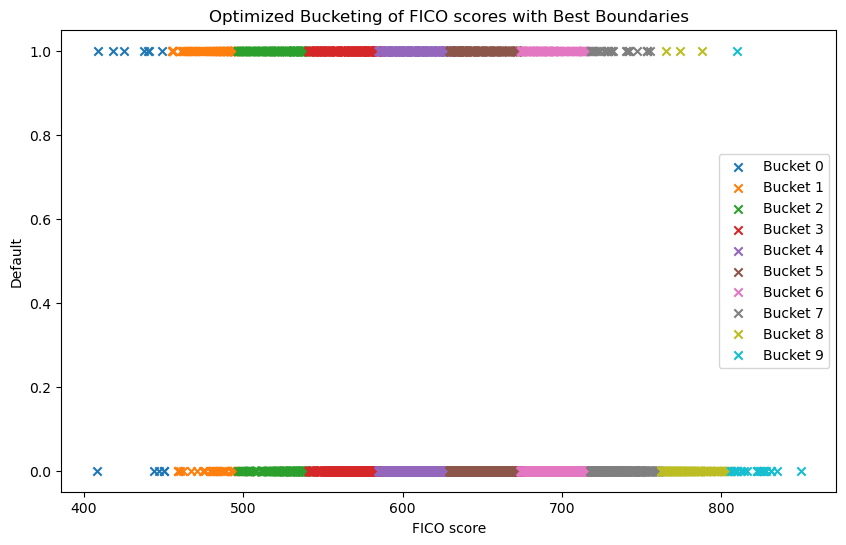

In [10]:
num_buck = best_count
final_boundaries = best_boundaries

fico["bucket"] = pd.cut(fico["fico_score"], bins = final_boundaries, labels = False, include_lowest = True)

plt.figure(figsize=(10, 6))
for b in range(num_buck):
    buck_data = fico[fico["bucket"] == b]
    plt.scatter(buck_data["fico_score"], buck_data["default"], label=f"Bucket {b}", marker = "x")
plt.xlabel("FICO score")
plt.ylabel("Default")
plt.legend()
plt.title("Optimized Bucketing of FICO scores with Best Boundaries")
plt.show()